<a href="https://colab.research.google.com/github/JanNogga/Vision_Systems_Lab/blob/main/Assignment_3/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Assignment 3

#### Setup

First we import required packages and seed the random number generators.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torchvision.utils import make_grid
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random as rand
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import numpy as np
import optuna
import joblib

In [2]:
# reject randomness (as much as possible)
manualSeed = 2021

np.random.seed(manualSeed)
rand.seed(manualSeed)
torch.manual_seed(manualSeed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(manualSeed)
    torch.cuda.manual_seed_all(manualSeed)

torch.backends.cudnn.enabled = False 
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

def _init_fn():
    np.random.seed(manualSeed)

Next, we create the training and validation sets, as well as the corresponding dataloaders.

In [3]:
### it should be beneficial to use some data augmentation here
transform_train = transforms.Compose(
    [transforms.ToTensor(),
     # legends say that these are the true values for SVHN
     transforms.Normalize((0.4376821, 0.4437697, 0.47280442), (0.19803012, 0.20101562, 0.19703614))])
transform_valid = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4376821, 0.4437697, 0.47280442), (0.19803012, 0.20101562, 0.19703614))])

# use this function when we want to plot the images
inv_normalize = transforms.Normalize(
    mean=[-0.4376821/0.19803012, -0.4437697/0.20101562, -0.47280442/0.19703614],
    std=[1/0.19803012, 1/0.20101562, 1/0.19703614]
)


trainset = dsets.SVHN('data', split='train', download=True, transform=transform_train)
testset = dsets.SVHN('data', split='test', download=True, transform=transform_valid)

BATCH_SIZE = 1024
train_loader = torch.utils.data.DataLoader(dataset=trainset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True,
                                           worker_init_fn=_init_fn)
 
valid_loader = torch.utils.data.DataLoader(dataset=testset, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=False,
                                          worker_init_fn=_init_fn)

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


We use a GPU if available.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is : {device}")

Device is : cuda


Next, we define a simple convolutional model. This is taken from the standard PyTorch image classification example and given some parameters to make the optuna studies interesting. Note that each layer has some padding to make calculation of the final output size easier.

In this version of the model, we modified the forward function to return the activations before pooling, because we want to visualize them below.

In [5]:
class Conv_Model(nn.Module):
    def __init__(self, input_channels, channels_1, kernel_1, channels_2, kernel_2, fc_1_neurons, fc_2_neurons,pool_mode, output_dim, p_drop_in, p_drop_conv, p_drop_fc):
        super().__init__()
        self.drop_in = nn.Dropout2d(p=p_drop_in)
        self.conv1 = nn.Conv2d(input_channels, channels_1, kernel_1, padding=kernel_1//2)
        self.drop_conv = nn.Dropout2d(p=p_drop_conv)
        if pool_mode == 'max':
            self.pool = nn.MaxPool2d(2, 2)
            self.out_size = 8
        elif pool_mode == 'avg':
            self.pool = nn.AvgPool2d(2,2)
            self.out_size = 8
        else:
            self.pool = lambda x: x
            self.out_size = 32
        self.conv2 = nn.Conv2d(channels_1, channels_2, kernel_2, padding=kernel_2//2)
        self.fc1 = nn.Linear(channels_2 * self.out_size * self.out_size, fc_1_neurons)
        self.drop_fc = nn.Dropout(p=p_drop_fc)
        self.fc2 = nn.Linear(fc_1_neurons, fc_2_neurons)
        self.fc3 = nn.Linear(fc_2_neurons, output_dim)

    def forward(self, x):
        x = self.drop_in(x)
        x_fm_1 = F.relu(self.conv1(x))
        x = self.pool(x_fm_1)
        x = self.drop_conv(x)
        x_fm_2 = F.relu(self.conv2(x))
        x = self.pool(x_fm_2)
        x = self.drop_conv(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.drop_fc(x)
        x = F.relu(self.fc2(x))
        x = self.drop_fc(x)
        x = self.fc3(x)
        return x, [x_fm_1, x_fm_2]

#### Task 1

*Train and compare the MLP from Assignment 2 and a simple CNN on the SVHN dataset (available in PyTorch) with optimized hyper-parameters.*

Just as for the previous assignment, we created separate *.py* files for the optuna studies. They are named after the type of model they are optimizing. This time, we did not use any trial pruning during the studies and ended training session based on an early stopping criterion. This way, the study objective of maximizing validation set accuracy should be more 'pure' than our attempts for the last sheet.

After running the studies for a day, the best discovered models were a fully connected network with about 10 million trainable parameters and an accuracy of about 87% as well as a convolutional model with about 100k parameters, achieving an accuracy of 89%. Both networks were fully trained in the notebook *Assignment_3_Model_Training.ipynb*. You can also find the learning curves and some further details for both training processes there. Obviously, the convolutional model is much more efficient than the massive fully connected network here, outperforming the large network even though it has only 1% of  the parameters. We load the best convolutional model in the cell below.

In [6]:
# load first study
study = joblib.load("SVHN_CONV.pkl")
trial_conv = study.best_trial

INPUT_CHANNELS = 3 # Immutable
CHANNELS_1 = trial_conv.params['channels_1'] 
KERNEL_1 = trial_conv.params['kernel_1'] 
CHANNELS_2 = trial_conv.params['channels_2'] 
KERNEL_2 = trial_conv.params['kernel_2'] 
FC_1_NEURONS = trial_conv.params['fc_1_neurons'] 
FC_2_NEURONS = trial_conv.params['fc_2_neurons'] 
POOL_MODE = trial_conv.params['pool_mode'] 
P_DROP_FC = trial_conv.params['p_drop_fc'] 
P_DROP_CONV = trial_conv.params['p_drop_conv'] 
P_DROP_IN = trial_conv.params['p_drop_in']
LEARNING_RATE = trial_conv.params['learning_rate']
OUTPUT_DIM = 10 #Immutable

model = Conv_Model(input_channels=INPUT_CHANNELS, channels_1=CHANNELS_1, kernel_1=KERNEL_1, channels_2=CHANNELS_2, kernel_2=KERNEL_2, fc_1_neurons=FC_1_NEURONS, fc_2_neurons=FC_2_NEURONS,pool_mode=POOL_MODE, output_dim=OUTPUT_DIM, p_drop_in=P_DROP_IN, p_drop_conv=P_DROP_CONV, p_drop_fc=P_DROP_FC)
model = model.to(device)

pretrained_params = torch.load('saved_models/conv_trained.pt')
model.load_state_dict(pretrained_params)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

criterion = nn.CrossEntropyLoss().to(device)
print('Number of trainable parameters:', count_parameters(model))

Number of trainable parameters: 134626


#### Task 2

*Visualize several convolutional kernels and their activations.*

We load some images from the validation set, pass them through the model and plot the feature maps.

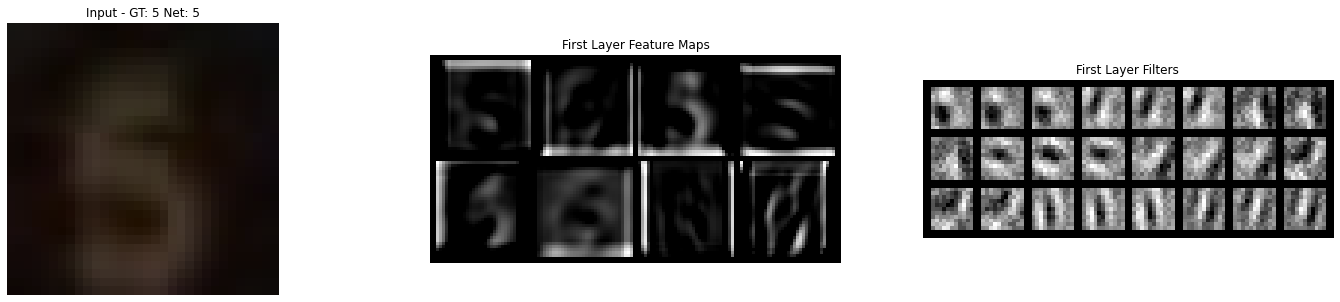

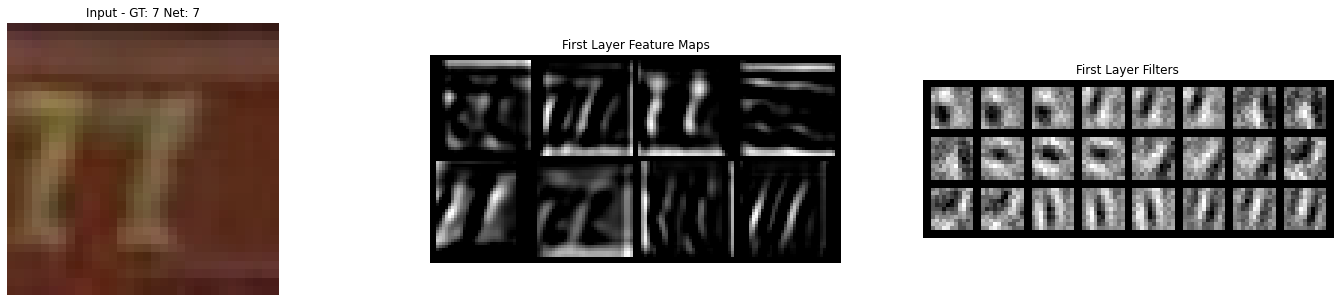

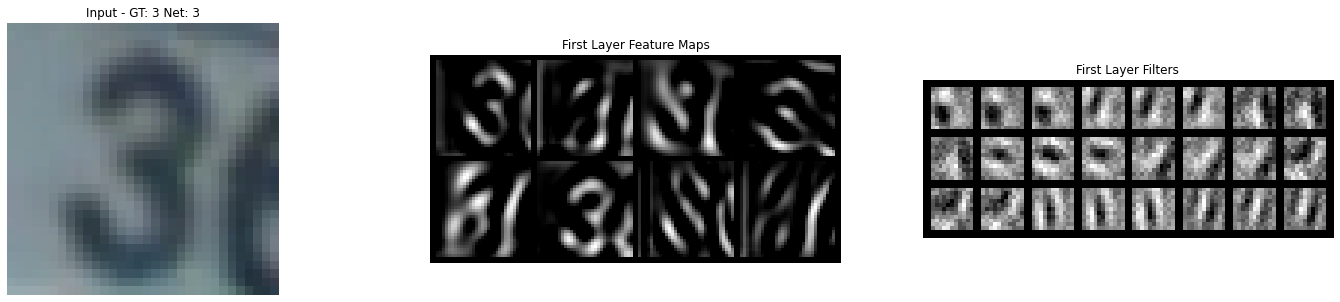

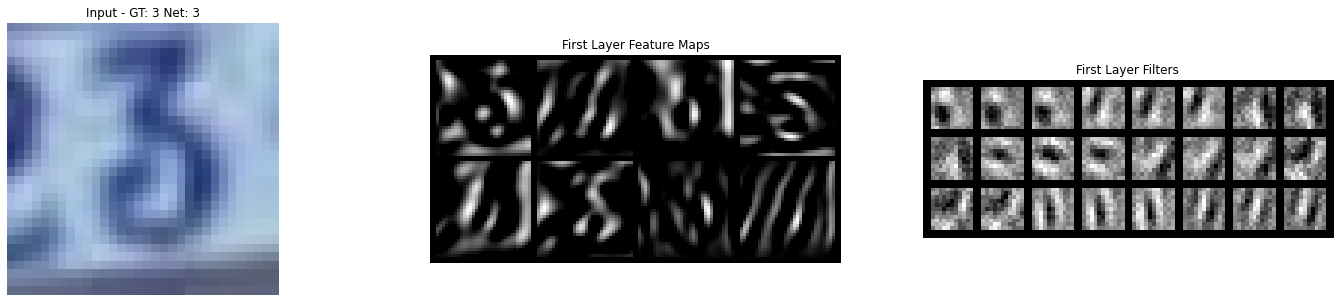

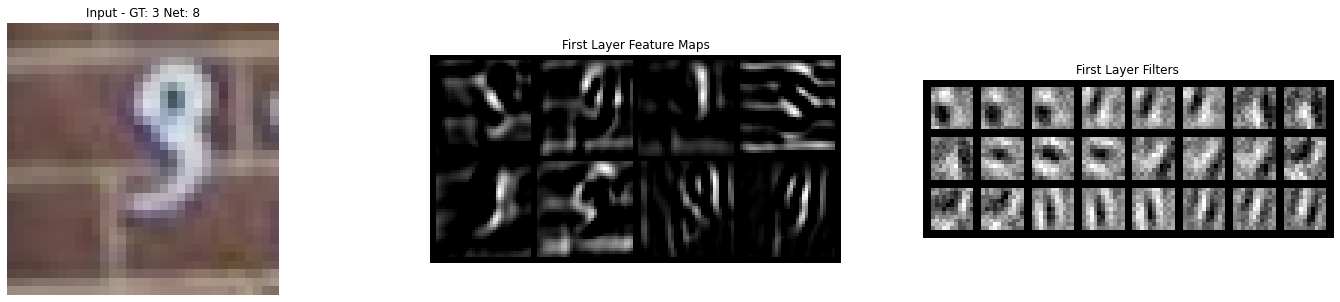

In [7]:
# tiny helper function
def show(img, ax):
    npimg = img.cpu().detach().numpy()
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

images, labels = next(iter(valid_loader))
model.eval()
with torch.no_grad():
    logits, feature_maps = model(images.to(device))
    
#show some feature maps at the first layer along with the corresponding filters
#it is also possible to plot this for the second layer but the images are too many to be legible
#note that these plots are before pooling, if used

for ind in np.random.permutation(images.shape[0])[:5]:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,5))
    show(inv_normalize(images[ind]), ax1)
    ax1.set_title('Input - GT: ' + str(labels[ind].item()) + ' Net: ' + str(logits[ind].cpu().argmax().item()))
    ax1.axis('off')
    show(make_grid(feature_maps[0][ind].unsqueeze(1),nrow=CHANNELS_1//2, ncol=2, normalize=True, scale_each=True), ax2)
    ax2.set_title('First Layer Feature Maps')
    ax2.axis('off')
    show(make_grid(model.conv1.weight.view(-1,1,KERNEL_1,KERNEL_1),nrow=CHANNELS_1, ncol=INPUT_CHANNELS, normalize=True, scale_each=True),ax3)
    ax3.set_title('First Layer Filters')
    ax3.axis('off')
    plt.show()

#### Observation

The filters themselves are not so easy to describe, as their sizes are relatively large compared to the input image ($11 \times 11$ vs $32 \times 32$), so, for example, sharp images showing only edges are not in the feature maps. Also, we are not entirely sure which kernels create which feature maps, as the standard setting for the number of groups in a conv layer is described by the pytorch docs as 'convolving all inputs to all outputs'. It would seem that each feature map depicted here is in fact a superposition of 3 feature maps. For the top right feature map, it seems that it is activated at horizontal edges, and it is missing the vertical ones.

#### Task 3

*Train CNNs with L1, L2, Elastic regularization and No-Regularization. Which method achieves the best results? compare the model performance. With which regularization do you obtain the best results?*

We reinitialize the conv model found by the optuna study for each experiment. To save some space in the notebook, the training process is moved to *trainer.py*. Regularization losses are calculated and then added to the loss of each batch with a weight of 1e-3. The same early stopping criterion as for the optuna study is used. We report the achieved validation accuracy, the number of training epochs, the total training time and the learning curve. Note that it is of course inefficient to have autograd determine the gradients by itself, but it allows us to define the regularization in the simple manner below.

In [7]:
from trainer import train

def L1_Regularization(net):
    loss = 0
    for name, param in net.named_parameters():
        if 'weight' in name:
            loss += torch.norm(param, 1)
    return loss

def L2_Regularization(net):
    loss = 0
    for name, param in net.named_parameters():
        if 'weight' in name:
            loss += torch.norm(param, 2)**2
    return loss

def elastic_Regularization(net):
    return 0.5*L1_Regularization(net) + 0.5*L2_Regularization(net)

def no_Regularization(net):
    return 0

Epoch 132 - Train: loss 1.4178 | acc 58.40 - Valid: loss 1.0987 | acc 66.09. :  52%|█████▏    | 131/250 [55:28<50:23, 25.41s/it]  

L1 regularization:
Acc: 66.09173331234304 Epochs: 131 Time: 3328.1990253925323


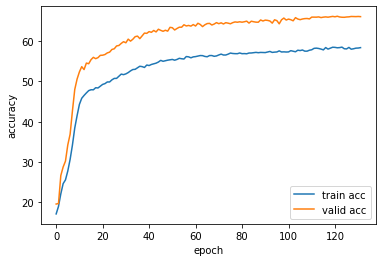

In [9]:
model_L1 = Conv_Model(input_channels=INPUT_CHANNELS, channels_1=CHANNELS_1, kernel_1=KERNEL_1, channels_2=CHANNELS_2, kernel_2=KERNEL_2, fc_1_neurons=FC_1_NEURONS, fc_2_neurons=FC_2_NEURONS,pool_mode=POOL_MODE, output_dim=OUTPUT_DIM, p_drop_in=P_DROP_IN, p_drop_conv=P_DROP_CONV, p_drop_fc=P_DROP_FC)

results_L1 = train(model_L1, trial_conv.params['learning_rate'], train_loader, valid_loader, L1_Regularization)

print('L1 regularization:')
print('Acc:', results_L1[0], 'Epochs:', results_L1[1], 'Time:', results_L1[2])

plt.plot(results_L1[3], label='train acc')
plt.plot(results_L1[4], label='valid acc')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

Epoch 73 - Train: loss 0.7351 | acc 79.27 - Valid: loss 0.3515 | acc 90.42. :  29%|██▉       | 72/250 [30:47<1:16:07, 25.66s/it]

L2 regularization:
Acc: 90.4233251007774 Epochs: 72 Time: 1847.3425078392029


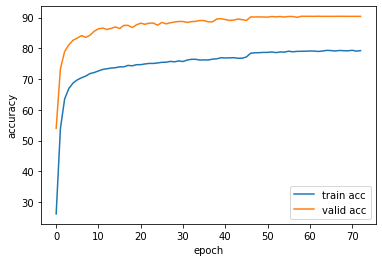

In [10]:
model_L2 = Conv_Model(input_channels=INPUT_CHANNELS, channels_1=CHANNELS_1, kernel_1=KERNEL_1, channels_2=CHANNELS_2, kernel_2=KERNEL_2, fc_1_neurons=FC_1_NEURONS, fc_2_neurons=FC_2_NEURONS,pool_mode=POOL_MODE, output_dim=OUTPUT_DIM, p_drop_in=P_DROP_IN, p_drop_conv=P_DROP_CONV, p_drop_fc=P_DROP_FC)

results_L2 = train(model_L2, trial_conv.params['learning_rate'], train_loader, valid_loader, L2_Regularization)

print('L2 regularization:')
print('Acc:', results_L2[0], 'Epochs:', results_L2[1], 'Time:', results_L2[2])

plt.plot(results_L2[3], label='train acc')
plt.plot(results_L2[4], label='valid acc')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

Epoch 127 - Train: loss 1.0208 | acc 72.37 - Valid: loss 0.4743 | acc 86.14. :  50%|█████     | 126/250 [53:27<52:36, 25.45s/it]  

Elastic regularization:
Acc: 86.14397655972397 Epochs: 126 Time: 3207.1417367458344


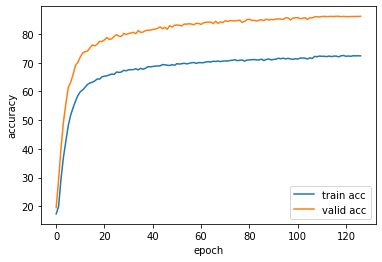

In [11]:
model_El = Conv_Model(input_channels=INPUT_CHANNELS, channels_1=CHANNELS_1, kernel_1=KERNEL_1, channels_2=CHANNELS_2, kernel_2=KERNEL_2, fc_1_neurons=FC_1_NEURONS, fc_2_neurons=FC_2_NEURONS,pool_mode=POOL_MODE, output_dim=OUTPUT_DIM, p_drop_in=P_DROP_IN, p_drop_conv=P_DROP_CONV, p_drop_fc=P_DROP_FC)

results_El = train(model_El, trial_conv.params['learning_rate'], train_loader, valid_loader, elastic_Regularization)

print('Elastic regularization:')
print('Acc:', results_El[0], 'Epochs:', results_El[1], 'Time:', results_El[2])

plt.plot(results_El[3], label='train acc')
plt.plot(results_El[4], label='valid acc')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

Epoch 49 - Train: loss 0.6209 | acc 78.75 - Valid: loss 0.3769 | acc 89.65. :  19%|█▉        | 48/250 [20:28<1:26:09, 25.59s/it]

No regularization:
Acc: 89.65119846393232 Epochs: 48 Time: 1228.4419310092926


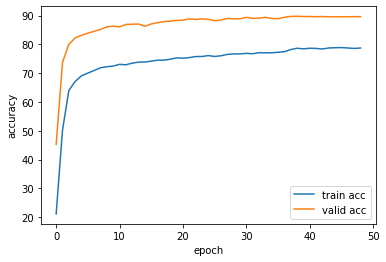

In [12]:
model_none = Conv_Model(input_channels=INPUT_CHANNELS, channels_1=CHANNELS_1, kernel_1=KERNEL_1, channels_2=CHANNELS_2, kernel_2=KERNEL_2, fc_1_neurons=FC_1_NEURONS, fc_2_neurons=FC_2_NEURONS,pool_mode=POOL_MODE, output_dim=OUTPUT_DIM, p_drop_in=P_DROP_IN, p_drop_conv=P_DROP_CONV, p_drop_fc=P_DROP_FC)

results_none = train(model_none, trial_conv.params['learning_rate'], train_loader, valid_loader, no_Regularization)

print('No regularization:')
print('Acc:', results_none[0], 'Epochs:', results_none[1], 'Time:', results_none[2])

plt.plot(results_none[3], label='train acc')
plt.plot(results_none[4], label='valid acc')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

#### Task 4

*Train CNNs with and without Dropout. Compare the results: accuracy, training time, number of parameters, ...*

Somewhat inexplicably, optuna selected a model without Dropout in the hidden layers, but with a high Dropout in the input layer. We test one model without any Dropout at all, and one model with a Dropout of 0.5 for the hidden layers, but not for the input. The number of parameters stay the same in these experiments.

Epoch 42 - Train: loss 0.1618 | acc 95.75 - Valid: loss 0.4089 | acc 89.54. :  16%|█▋        | 41/250 [17:37<1:29:50, 25.79s/it]

No Dropout:
Acc: 89.53595586869346 Epochs: 41 Time: 1057.5297005176544


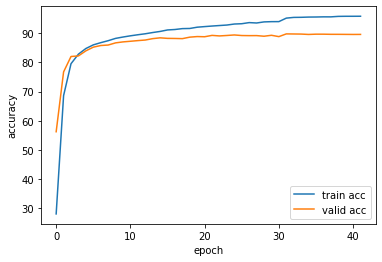

In [13]:
model_no_drop = Conv_Model(input_channels=INPUT_CHANNELS, channels_1=CHANNELS_1, kernel_1=KERNEL_1, channels_2=CHANNELS_2, kernel_2=KERNEL_2, fc_1_neurons=FC_1_NEURONS, fc_2_neurons=FC_2_NEURONS,pool_mode=POOL_MODE, output_dim=OUTPUT_DIM, p_drop_in=0., p_drop_conv=0., p_drop_fc=0.)

results_no_drop = train(model_no_drop, trial_conv.params['learning_rate'], train_loader, valid_loader, no_Regularization)

print('No Dropout:')
print('Acc:', results_no_drop[0], 'Epochs:', results_no_drop[1], 'Time:', results_no_drop[2])

plt.plot(results_no_drop[3], label='train acc')
plt.plot(results_no_drop[4], label='valid acc')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

Epoch 76 - Train: loss 0.7142 | acc 78.95 - Valid: loss 0.4501 | acc 87.33. :  30%|███       | 75/250 [31:50<1:14:17, 25.47s/it]

Hidden Layer Dropout:
Acc: 87.33097727751542 Epochs: 75 Time: 1910.220644235611


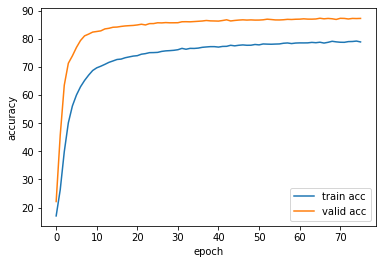

In [14]:
model_drop = Conv_Model(input_channels=INPUT_CHANNELS, channels_1=CHANNELS_1, kernel_1=KERNEL_1, channels_2=CHANNELS_2, kernel_2=KERNEL_2, fc_1_neurons=FC_1_NEURONS, fc_2_neurons=FC_2_NEURONS,pool_mode=POOL_MODE, output_dim=OUTPUT_DIM, p_drop_in=0., p_drop_conv=0.5, p_drop_fc=0.5)

results_drop = train(model_drop, trial_conv.params['learning_rate'], train_loader, valid_loader, no_Regularization)

print('Hidden Layer Dropout:')
print('Acc:', results_drop[0], 'Epochs:', results_drop[1], 'Time:', results_drop[2])

plt.plot(results_drop[3], label='train acc')
plt.plot(results_drop[4], label='valid acc')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

#### Task 5

*Train CNNs with the following Pooling methods: MaxPooling, AvgPooling or a combination of both and compare the results*

Here we do not test AvgPooling, as it is already the pooling which optuna selected, so our original model already uses it.

Epoch 45 - Train: loss 0.6433 | acc 78.12 - Valid: loss 0.4060 | acc 89.29. :  18%|█▊        | 44/250 [18:53<1:28:28, 25.77s/it]

Max Pooling:
Acc: 89.29394590334432 Epochs: 44 Time: 1133.8540456295013


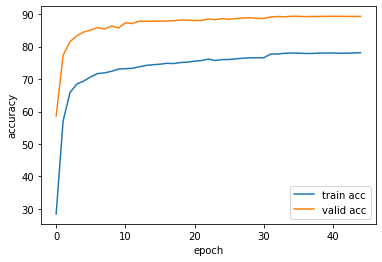

In [15]:
model_max = Conv_Model(input_channels=INPUT_CHANNELS, channels_1=CHANNELS_1, kernel_1=KERNEL_1, channels_2=CHANNELS_2, kernel_2=KERNEL_2, fc_1_neurons=FC_1_NEURONS, fc_2_neurons=FC_2_NEURONS,pool_mode='max', output_dim=OUTPUT_DIM, p_drop_in=P_DROP_IN, p_drop_conv=P_DROP_CONV, p_drop_fc=P_DROP_FC)

results_max = train(model_max, trial_conv.params['learning_rate'], train_loader, valid_loader, no_Regularization)

print('Max Pooling:')
print('Acc:', results_max[0], 'Epochs:', results_max[1], 'Time:', results_max[2])

plt.plot(results_max[3], label='train acc')
plt.plot(results_max[4], label='valid acc')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

Epoch 42 - Train: loss 0.5968 | acc 79.53 - Valid: loss 0.4974 | acc 87.70. :  16%|█▋        | 41/250 [17:57<1:31:34, 26.29s/it]

No Pooling:
Acc: 87.69591270404574 Epochs: 41 Time: 1077.882702589035


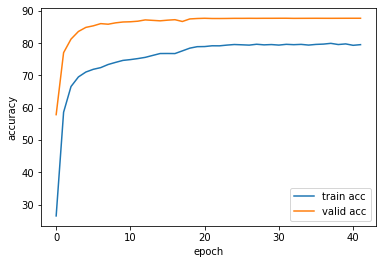

In [8]:
model_no_pool = Conv_Model(input_channels=INPUT_CHANNELS, channels_1=CHANNELS_1, kernel_1=KERNEL_1, channels_2=CHANNELS_2, kernel_2=KERNEL_2, fc_1_neurons=FC_1_NEURONS, fc_2_neurons=FC_2_NEURONS,pool_mode='none', output_dim=OUTPUT_DIM, p_drop_in=P_DROP_IN, p_drop_conv=P_DROP_CONV, p_drop_fc=P_DROP_FC)

results_no_pool = train(model_no_pool, trial_conv.params['learning_rate'], train_loader, valid_loader, no_Regularization)

print('No Pooling:')
print('Acc:', results_no_pool[0], 'Epochs:', results_no_pool[1], 'Time:', results_no_pool[2])

plt.plot(results_no_pool[3], label='train acc')
plt.plot(results_no_pool[4], label='valid acc')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

### Conclusion

Regularization seems to have a destabilizing effect on the training process in this case, as is evident by an increase in jitter across the validation accuracy scores. Nevertheless, L2 regularization barely outperforms our otherwise identical model, so this might have some benefits here.

Omitting dropout quickly causes the model to overfit on the training set, even though the achieved validation accuracy is nonetheless still fine. It is concievable that narrower fully connected layers at the end of the model would have been sufficient. Also, performance on the training set is kept very low when using dropout. It would seem that the dropout currently set, especially the dropout applied to the input layer, is too severe, some fine-tuning is probably beneficial. As for pooling, max pooling does not improve, nor significantly decrease the performance of the trained model. On the other hand, using no pooling yields no benefits but at the same time increases the number of model parameters due to the large size of the models first fully connected layer.

Overall, it is at least encouraging that for 'neighboring' model configurations, none performed better than the one proposed by optuna. The L2 Regularization experiment does not count here, because optuna was not granted access to that parameter, all trials were run without regularization. However, it should be noted that none of our findings here are conclusive, as our model combines all of these design elements, and none can be properly isolated without conducting a vast number of experiments.